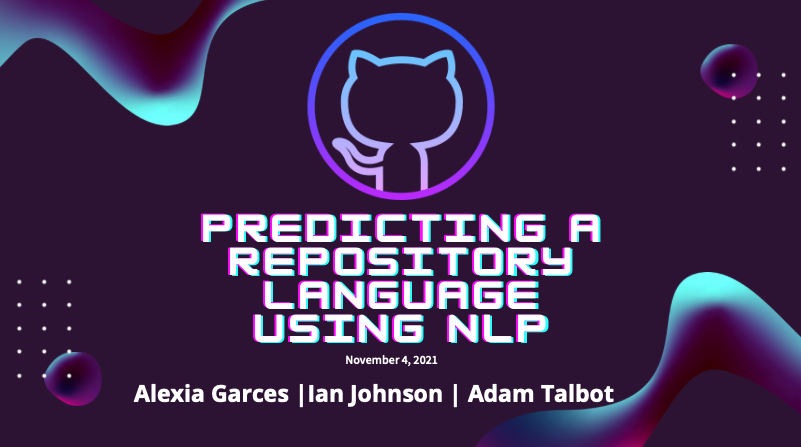

# 🎯 Project Overview and Goals

## Goal:
To use web scraping to acquire data from  the most forked GitHub repository README files and build a model that can predict what programming language a repository is, given the text of the README file.

## Overview & Scope:
We decided to scrape the top 500 most forked Github repositorys to acquire the data for this project.  Using this data, we found the top 4 most common languages to use as the targets for modeling.  These four languages were JavaScript, Java, Python, and C++. 


# Executive Summary

# 📥 Imports

In [39]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from time import strftime
import numpy as np

import scrape_url_list as s
import acquire as a
import prepare as p
import explore as e

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import unicodedata
import re

from wordcloud import WordCloud
from os import path
from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# visualization settings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('seaborn-darkgrid')
#select seaborn color palette
sns.set_palette('plasma')
pal = sns.set_palette('plasma')
print(sns.color_palette().as_hex())

['#5302a3', '#8b0aa5', '#b83289', '#db5c68', '#f48849', '#febd2a']


# 📥 Acquire Data
1. The urls for the most forked github repositories were acquired using webscraping.  A function was created that automated the scraping of the urls from each of the top 500 most forked repositories.
2. After acquiring the urls for the repos, we used a function provided to use Github's API to acquire the language, repo name/url, and the readme contents for all the repos into a json file that we will read in below.

Below we will use the acquire function found in our acquire.py file to bring in this project's data.  For more details on the process used, see our acquire.py file.

In [2]:
df = pd.read_json('data.json')
df.head()

,repo,language,readme_contents
0,jtleek/datasharing,None,How to share data with a statistician\n=======...
1,rdpeng/ProgrammingAssignment2,R,### Introduction\n\nThis second programming as...
2,octocat/Spoon-Knife,HTML,### Well hello there!\n\nThis repository is me...
3,tensorflow/tensorflow,C++,"<div align=""center"">\n <img src=""https://www...."
4,SmartThingsCommunity/SmartThingsPublic,Groovy,# SmartThings Public GitHub Repo\n\nAn officia...


In [3]:
df.shape

(500, 3)

In [4]:
# Look at the number of repositories for each language.
df.language.value_counts(dropna=False)

JavaScript          100
Java                 77
NaN                  60
Python               54
C++                  30
TypeScript           26
Jupyter Notebook     26
Go                   19
HTML                 16
C                    15
PHP                  12
Ruby                 11
Shell                 8
CSS                   5
Kotlin                5
Swift                 4
C#                    4
Vue                   3
Rascal                3
Scala                 2
R                     2
Objective-C           2
Dart                  2
Nix                   2
TeX                   1
Assembly              1
Groovy                1
Rich Text Format      1
ApacheConf            1
Dockerfile            1
Rust                  1
PowerShell            1
Less                  1
SCSS                  1
Vim script            1
Nunjucks              1
Name: language, dtype: int64

In [5]:
df.isna().sum()

repo                0
language           60
readme_contents     0
dtype: int64

## Acquire Takeaways:
- The languages present, we will select the top four represented languages:
        - JavaScript
        - Java
        - Python
        - C++
- To reduce the number of target languages rather than keeping the other languages that would create noise and decrease model preformance.  Lack of samples and subclasses.
- Rows containing the other languages will be removed from the data
- all nulls will be deleted as part of prep

# 🧹 Prepare Data

During this stage we will use the a function from our prepare.py file.  This function will do the following to prep our data for exploration and modeling:
- Complete a basic clean on the contents to lowercase all characters, normalize unicode characters, and romeve all characters that are not a letter or space.  We decided to drop numbers from the data set because there was no value******.
- Tokenize the content to break text down into discrete words, punctuation, etc.
- Remove stopwords using the standard English language stopwords
- create a new columns for cleaned, stemmed and lemmatized readme contents.

To see how this process was completed, please reference the prepare.py file in our repository.

In [6]:
#added extra word '&#9:' because it was coming through still after cleaning.
df = p.prep_nlp(df, original_text_col='readme_contents', extra_words = ['&#9;'])
df.head()

,repo,language,readme_contents,clean,stemmed,lemmatized
3,tensorflow/tensorflow,C++,"<div align=""center"">\n <img src=""https://www....",div aligncenter img srchttpswwwtensorfloworgim...,div aligncent img srchttpswwwtensorfloworgimag...,div aligncenter img srchttpswwwtensorfloworgim...
5,twbs/bootstrap,JavaScript,"<p align=""center"">\n <a href=""https://getboot...",p aligncenter hrefhttpsgetbootstrapcom img src...,p aligncent hrefhttpsgetbootstrapcom img srcht...,p aligncenter hrefhttpsgetbootstrapcom img src...
8,nightscout/cgm-remote-monitor,JavaScript,Nightscout Web Monitor (a.k.a. cgm-remote-moni...,nightscout web monitor aka cgmremotemonitor ni...,nightscout web monitor aka cgmremotemonitor ni...,nightscout web monitor aka cgmremotemonitor ni...
11,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...,opencv open source computer vision library res...,opencv open sourc comput vision librari resour...,opencv open source computer vision library res...
13,CyC2018/CS-Notes,Java,"<div align=""center"">\r\n <a href=""https://w...",div aligncenter hrefhttpswwwcycxyz img srchttp...,div aligncent hrefhttpswwwcycxyz img srchttpsb...,div aligncenter hrefhttpswwwcycxyz img srchttp...


In [7]:
df.shape

(261, 6)

## Prepare Takeaways:
- After removing nulls and including only repositories of the top four langages JavaScript, Java, Python, and C++ we are left with a data set with 261 repos out of the 500 Most Forked Github Repositories.

# ✂️ Split Data

We will now split our data in order to move forward with exploration on train and modeling.

- Use function from our prepare.py to split data into train, validate, and test data sets using a 60%-20%-20% split and to will statify for the target column - language.

In [8]:
train, validate, test = p.split_readme(df)

Train Proportion: 0.60 (156 rows)
Validate Proportion: 0.20 (52 rows)    
Test Proportion: 0.20 (53 rows)


# 🔍 Exploratory Data Analysis

In [9]:
# Rename train to df in order to explore on train data set with simplified code
df = train.copy()

### First let's look at the number of repositories for each of our target languages.

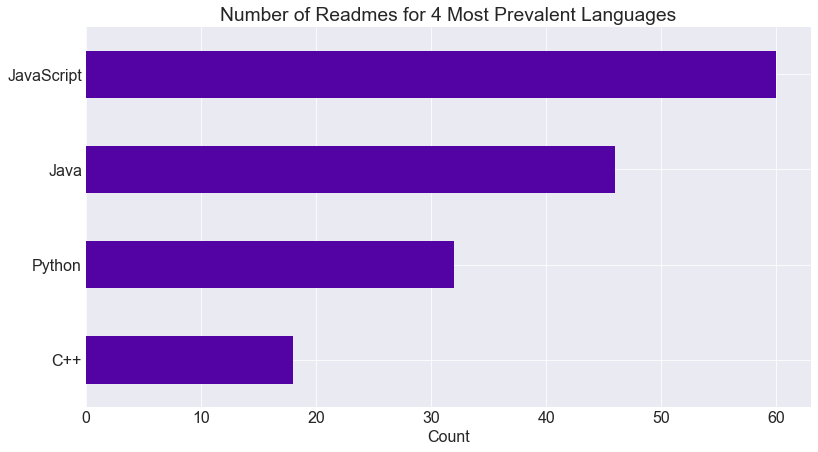

In [10]:
df.language.value_counts().sort_values(ascending = True).plot.barh()
plt.title('Number of Readmes for 4 Most Prevalent Languages')
plt.xlabel("Count");

### Now we will create a word_count df that we will use to explore the frequency of of the words for each language.

In [11]:
# combine all readmes for each class into a single string
js_words = ' '.join(df[df.language == 'JavaScript'].clean)
j_words = ' '.join(df[df.language == 'Java'].clean)
py_words = ' '.join(df[df.language == 'Python'].clean)
c_words = ' '.join(df[df.language == 'C++'].clean)
all_words = ' '.join(df.clean)

#represent all words for each language as frequencies
js_freq = pd.Series(js_words.split()).value_counts()
j_freq = pd.Series(j_words.split()).value_counts()
py_freq = pd.Series(py_words.split()).value_counts()
c_freq = pd.Series(c_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

# concat all frequencies together into single df
word_counts = pd.concat([js_freq, j_freq, py_freq, c_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['JavaScript', 'Java', 'Python', 'C++', 'All']
word_counts.head()

,JavaScript,Java,Python,C++,All
javascript,784,13,34,3,834
const,354,0,0,52,406
function,347,1,5,17,370
td,309,13,10,2,334
tr,295,128,0,15,438


## Top 20 Words

In [54]:
top20 = word_counts.sort_values('All', ascending=False).head(20)
top20

,JavaScript,Java,Python,C++,All
javascript,784,13,34,3,834
use,254,85,217,44,600
code,239,81,174,43,537
learning,24,0,483,24,531
tr,295,128,0,15,438
data,102,22,283,29,436
python,8,10,382,35,435
using,125,42,177,67,411
const,354,0,0,52,406
machine,4,1,368,9,382


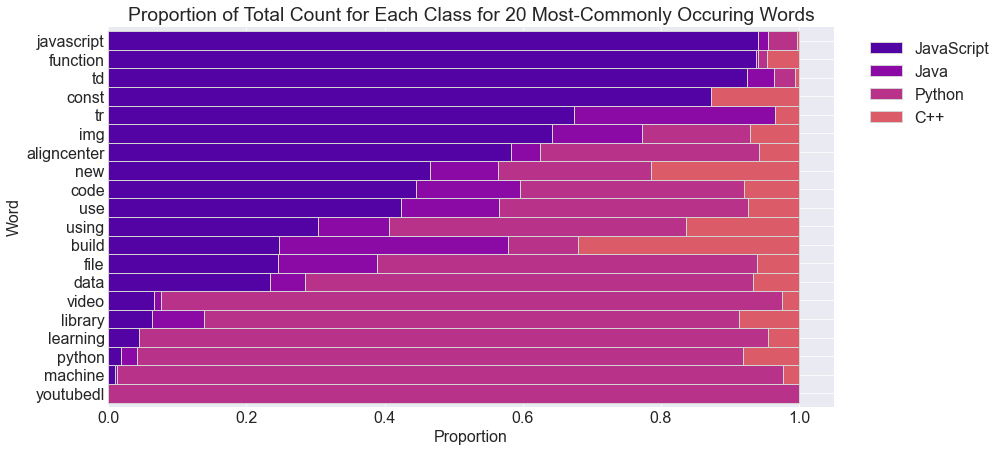

In [12]:
e.plot_stacked_all(word_counts)

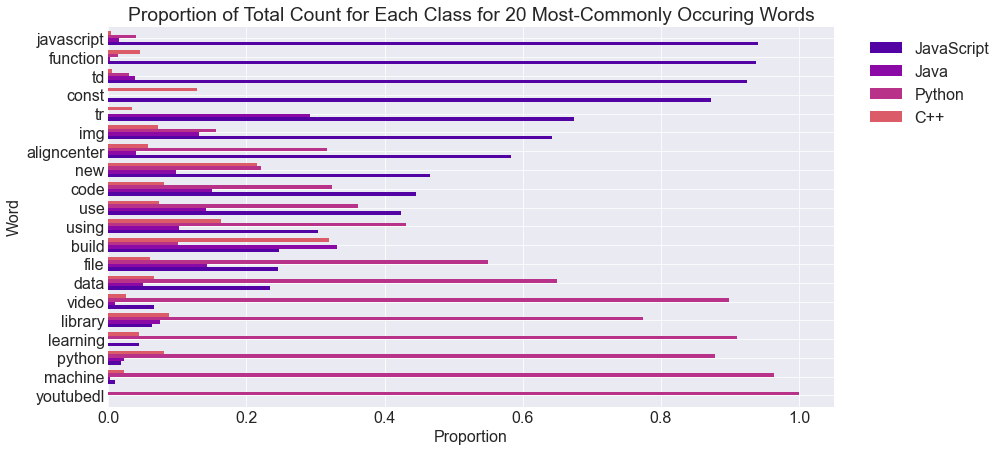

In [13]:
e.plot_bar_all(word_counts)

### Top 20 Word Takeaways:
- Interesting that function isn't common in Python Readme words
- Python has two video related terms in the Top 20 words: video & youtubedl which is used to embed a youtube video into a readme.
- Data is prevalent in both JavaScript and Python
- Use/using & build are very common across all languages.

<Figure size 1152x648 with 0 Axes>

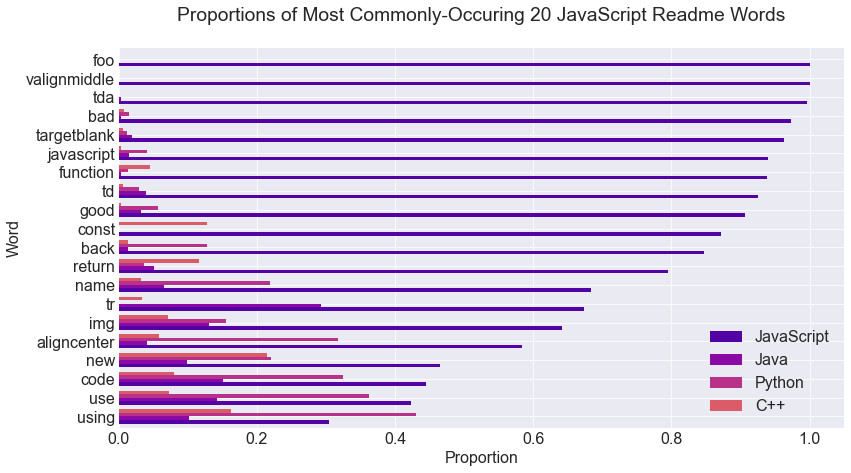

In [14]:
e.plot_horizontal_bar(word_counts, 'JavaScript', num_top = 20)

<Figure size 1152x648 with 0 Axes>

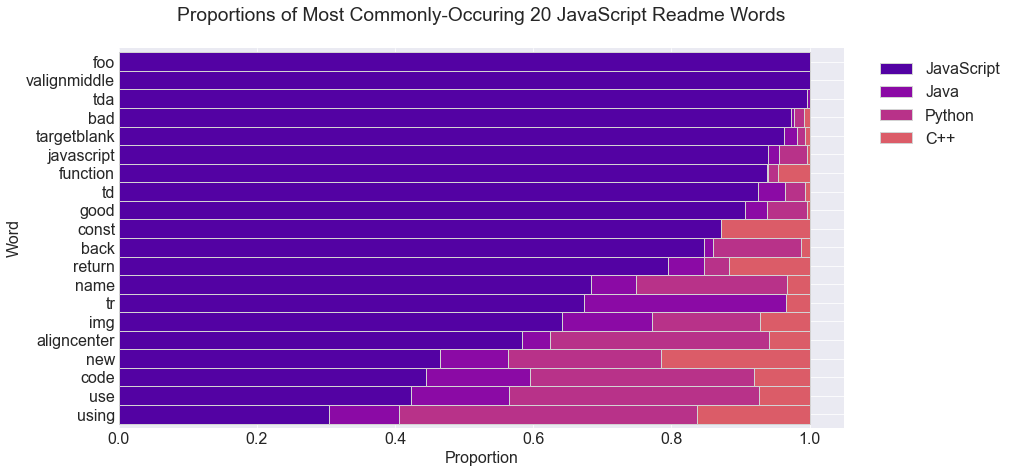

In [15]:
e.plot_stacked_bar(word_counts, 'JavaScript', num_top = 20)

### JavaScript Top 20 Words Takeaways:
- Most of the top 10 words are unique to JavaScript
- "Function" is very prevalent in JavaScript readmes
- "Good" and "bad" are very common in JavaScript and not other languages

<Figure size 1152x648 with 0 Axes>

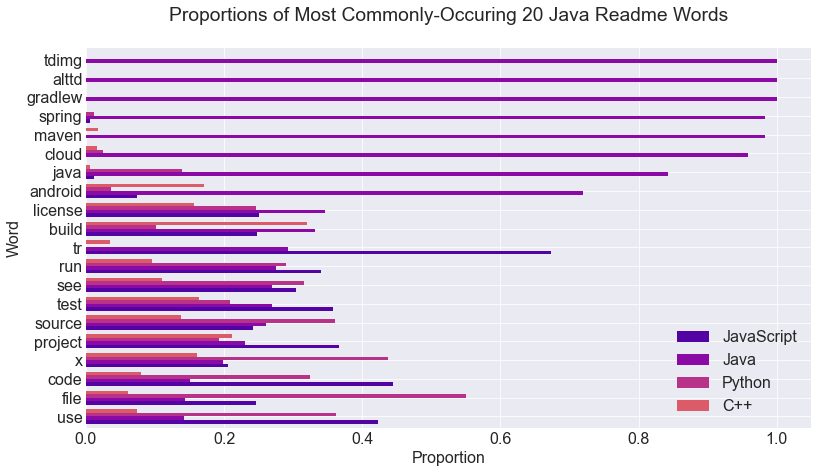

In [16]:
e.plot_horizontal_bar(word_counts, 'Java', num_top = 20)

<Figure size 1152x648 with 0 Axes>

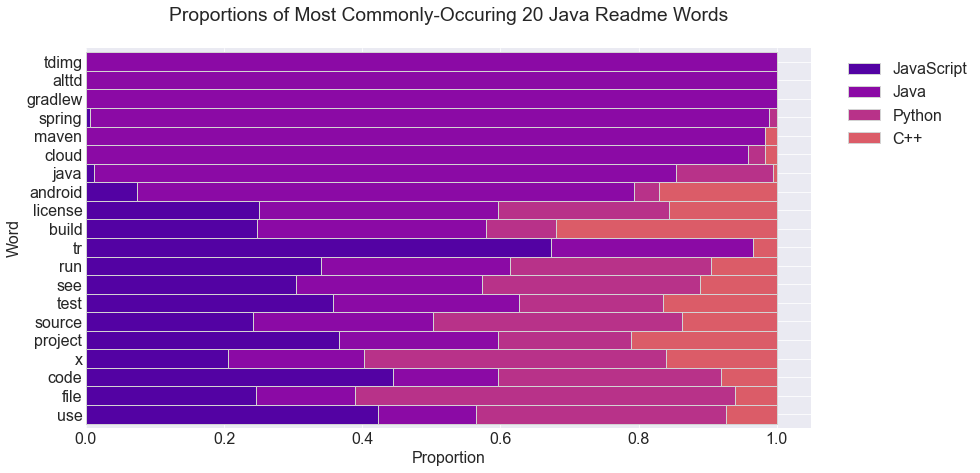

In [17]:
e.plot_stacked_bar(word_counts, 'Java', num_top = 20)

### Top 20 Java Readme Words Takeaways:
- The top 8 words are the most unique to Java the rest begin to become more prevalent in other languages
- Java is the only language with "cloud" as a top word showing the language tends to work with cloud computing.
- "Android" is most prevalent in Java readmes.

<Figure size 1152x648 with 0 Axes>

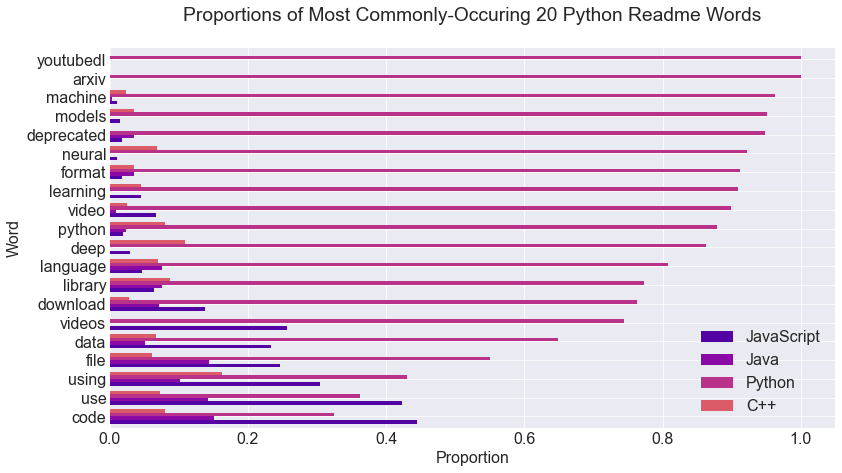

In [56]:
e.plot_horizontal_bar(word_counts, 'Python', num_top = 20)

<Figure size 1152x648 with 0 Axes>

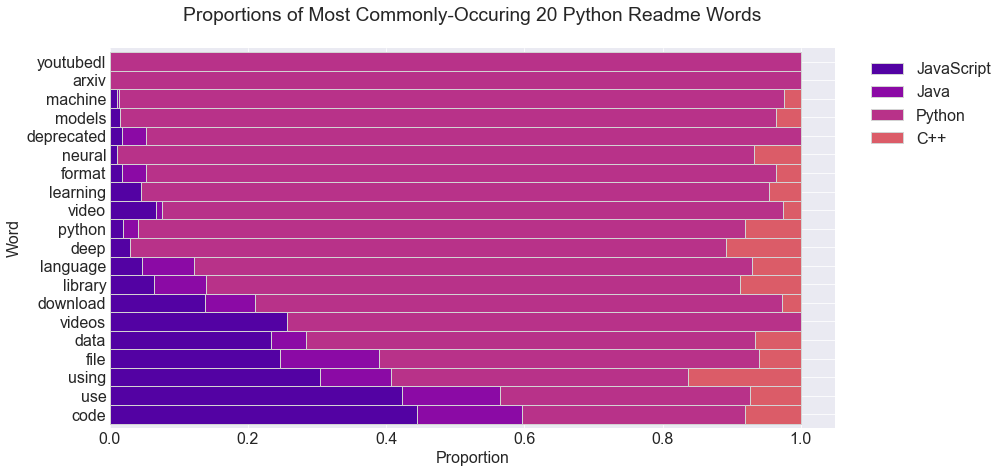

In [19]:
e.plot_stacked_bar(word_counts, 'Python', num_top = 20)

### Top 20 Python Readme Words Takeaways:
- Python seems to have the most unique top words compared to other languages.
- As mentioned earlier the video words "video" & "youtubed" are related to the fact that a lot of Python Readmes have videos embedded into them.
- Heavy prevalence of data science & machine learning vocabulary

<Figure size 1152x648 with 0 Axes>

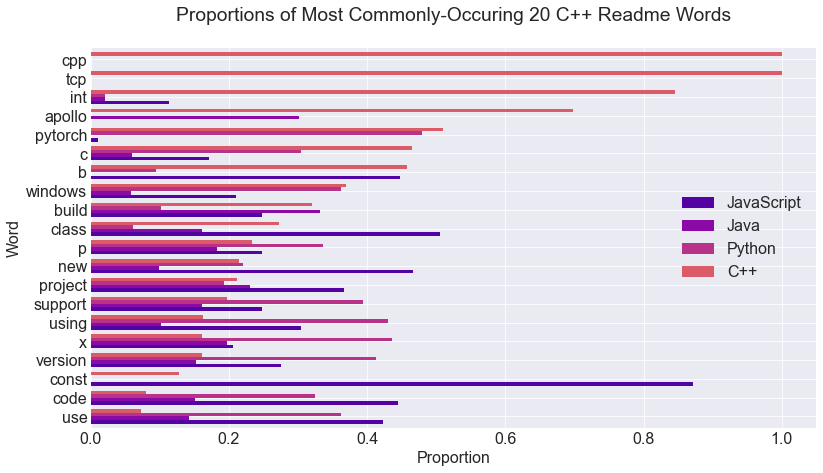

In [20]:
e.plot_horizontal_bar(word_counts, 'C++', num_top = 20)

<Figure size 1152x648 with 0 Axes>

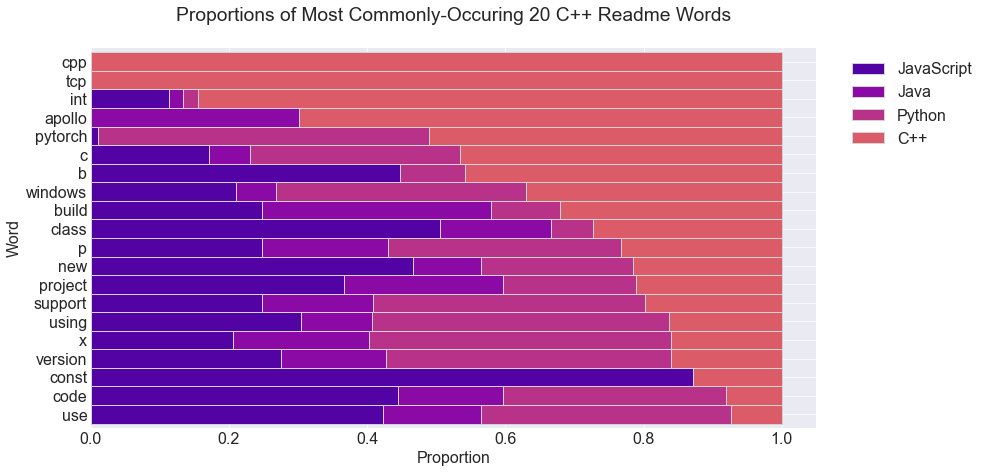

In [21]:
e.plot_stacked_bar(word_counts, 'C++', num_top = 20)

In [ ]:
### C++ 
- cpp  .cpp file extension .tcp
- smallest sample set least amount of prevalent words

Overall:
    - Language name alway in top 10 with exception of C++ due to cleaning
    - JavaScript and Python have the largest number of words that are unique to the language compared to C++ and Java

## Top 20 Bigrams for Each Language

In [22]:
all_words_list = [js_words, j_words, py_words, c_words, all_words]
# create list of languages
languages = list(df.language.unique())

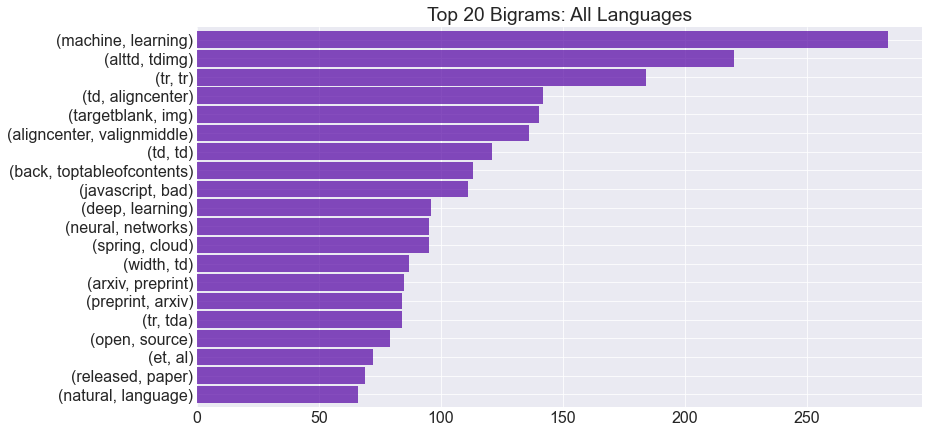

In [29]:
e.bigram_count(all_words, lang_name = 'All Languages')

foo bar
spring cloud = framework for building cloud applications
- bigrams pulled out tools or common use terms

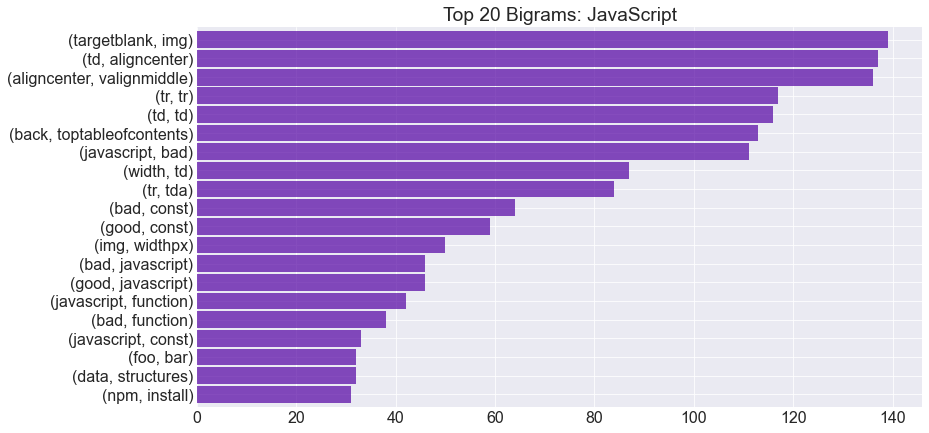

In [30]:
e.bigram_count(js_words, lang_name = 'JavaScript')

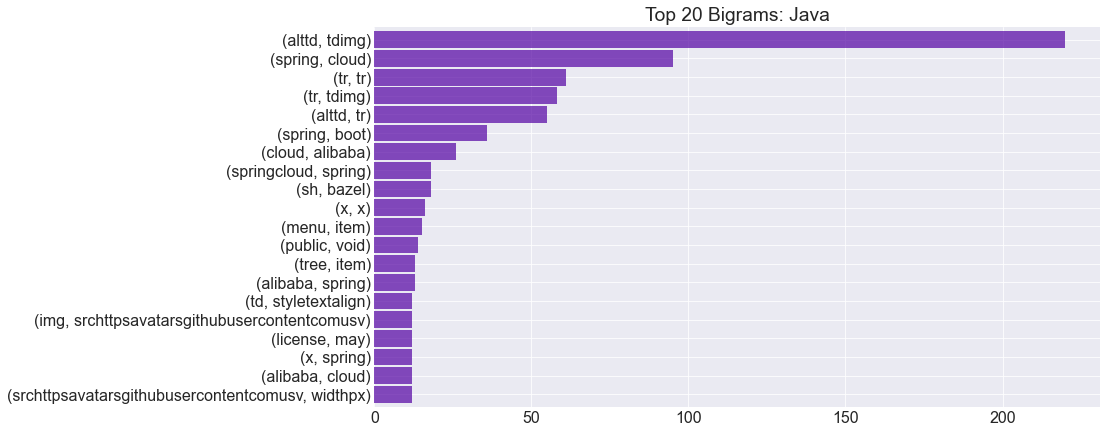

In [31]:
e.bigram_count(j_words, lang_name = 'Java')

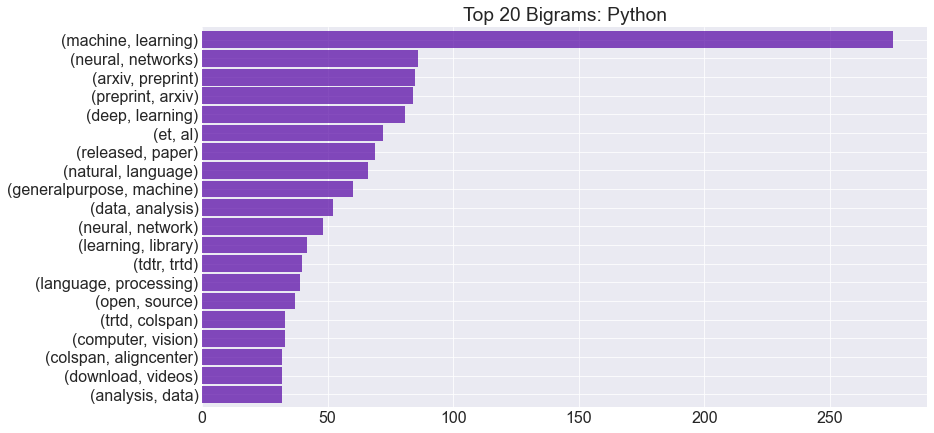

In [32]:
e.bigram_count(py_words, lang_name = 'Python')

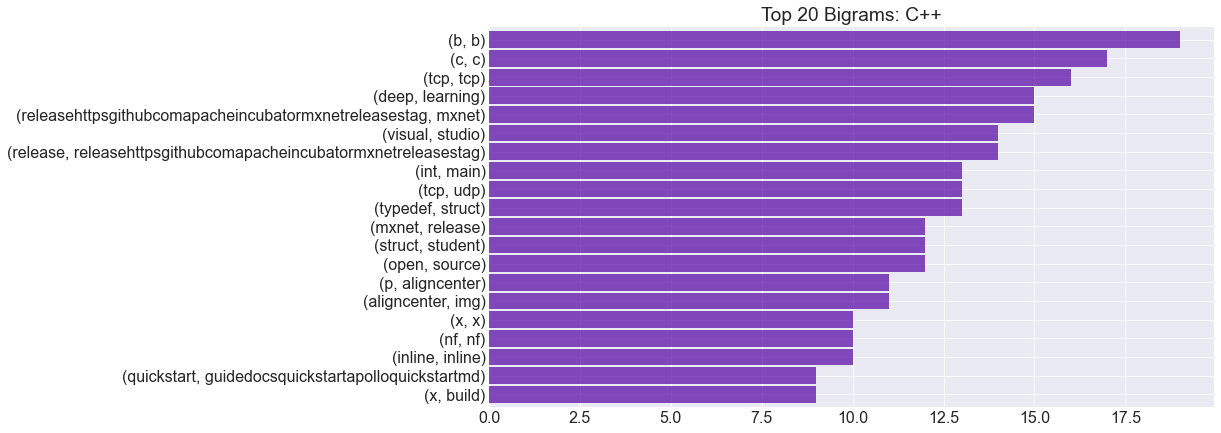

In [33]:
e.bigram_count(c_words, lang_name = 'C++')

## Top 10 Trigrams for Each Language

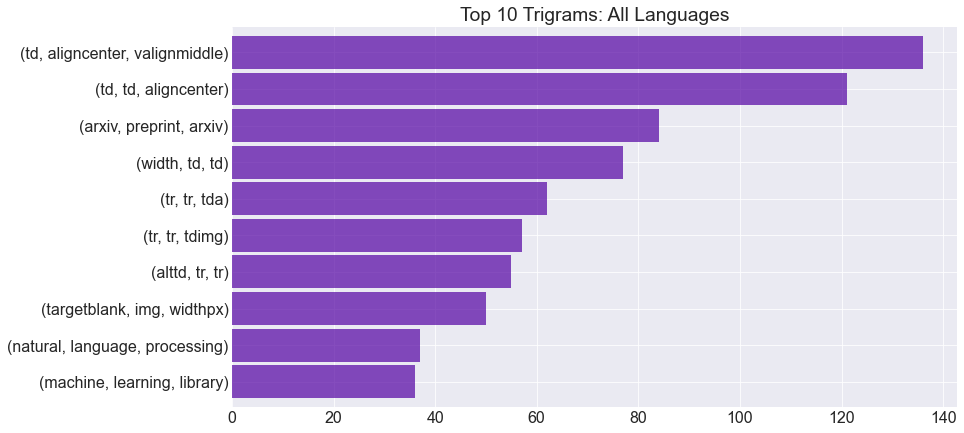

In [34]:
e.trigram_count(all_words, lang_name = 'All Languages')

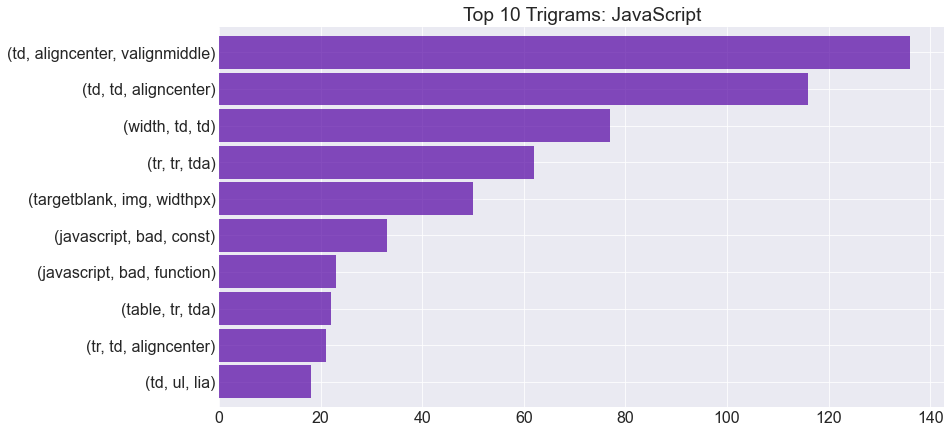

In [35]:
e.trigram_count(js_words, lang_name = 'JavaScript')

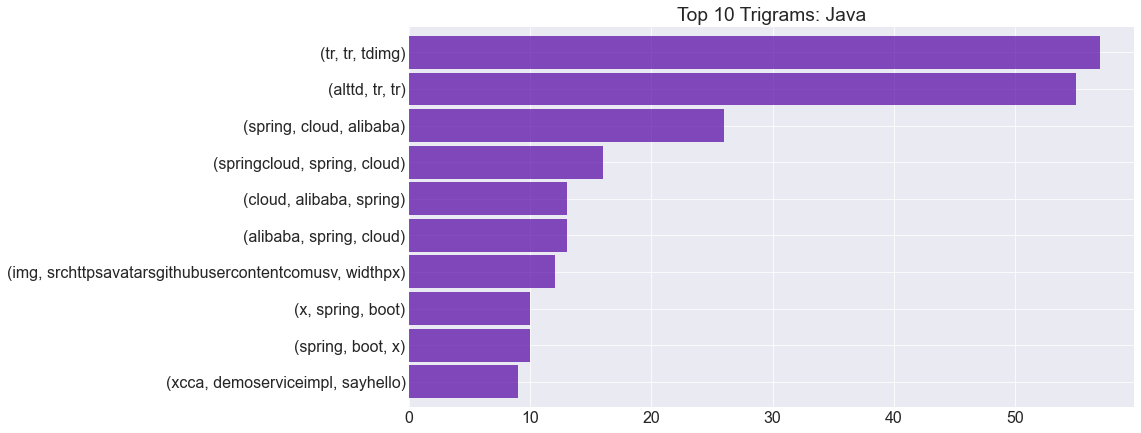

In [36]:
e.trigram_count(j_words, lang_name = 'Java')

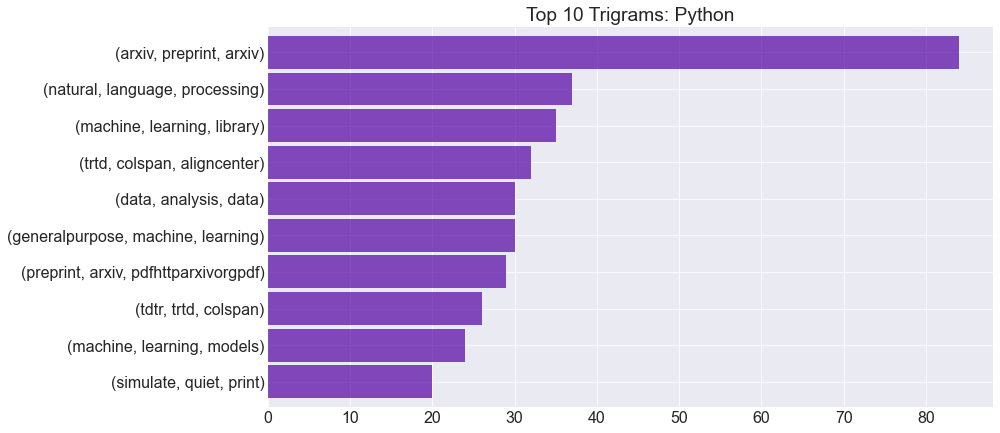

In [37]:
e.trigram_count(py_words, lang_name = 'Python')

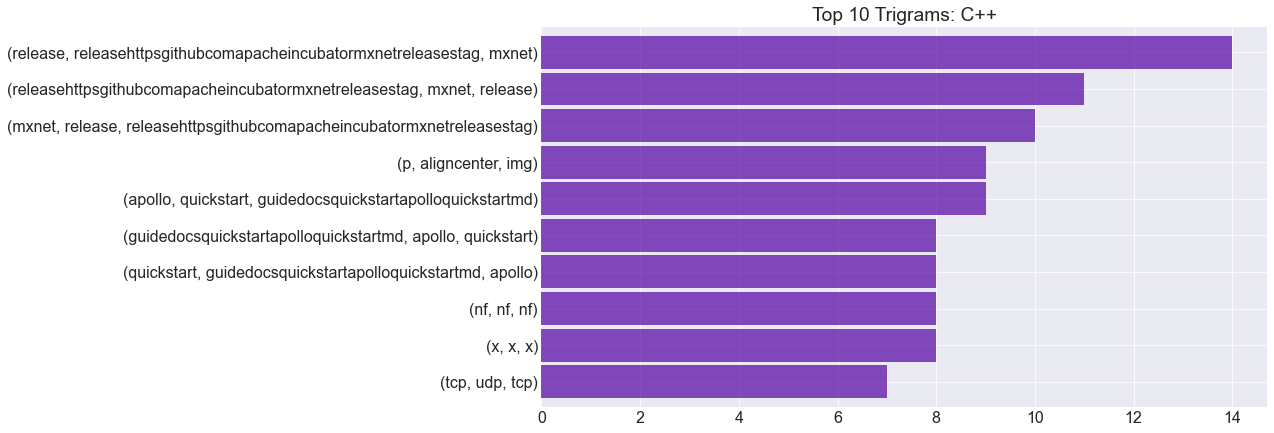

In [57]:
e.trigram_count(c_words, lang_name = 'C++')

- C++ closer to machine language vs descriptive - different programming culture

## Word Clouds for All Languages & Each Language

### All Languages

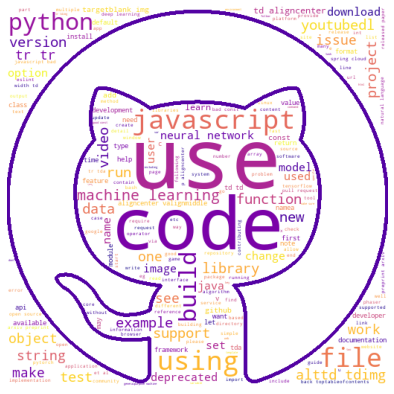

In [43]:
g_mask = np.array(Image.open("G.png"))
wc = WordCloud(background_color="white", colormap='plasma', mask=g_mask, contour_width=5, contour_color='#5302a3').generate(all_words)
plt.imshow(wc)
plt.axis("off")
plt.show()

### JavaScript Word Cloud

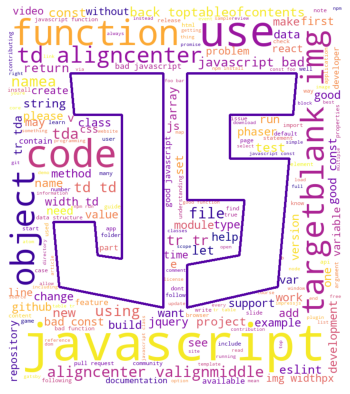

In [50]:
js_mask = np.array(Image.open("JS.png"))
wc = WordCloud(background_color="white", colormap='plasma', mask=js_mask, contour_width=5, contour_color='#5302a3').generate(js_words)
plt.imshow(wc)
plt.axis("off")
plt.show()

### Java Word Cloud

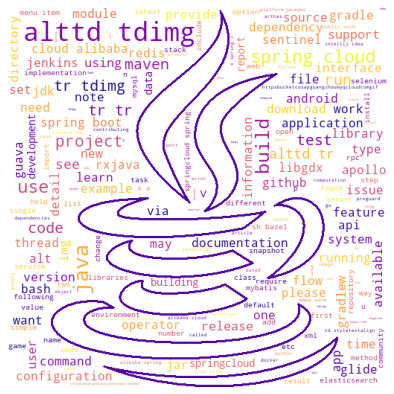

In [46]:
j_mask = np.array(Image.open("J1.png"))
wc = WordCloud(background_color="white",colormap='plasma', mask=j_mask, contour_width=2, contour_color='#5302a3').generate(j_words)
plt.imshow(wc)
plt.axis("off")
plt.show()

### Python Word Cloud

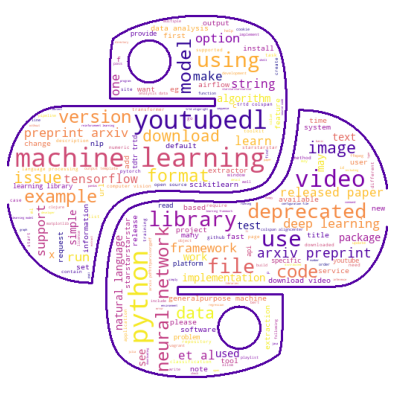

In [48]:
py_mask = np.array(Image.open("Py.png"))
wc = WordCloud(background_color="white",colormap='plasma', mask=py_mask, contour_width=2, contour_color='#5302a3').generate(py_words)
plt.imshow(wc)
plt.axis("off")
plt.show()

### C++ Word Cloud

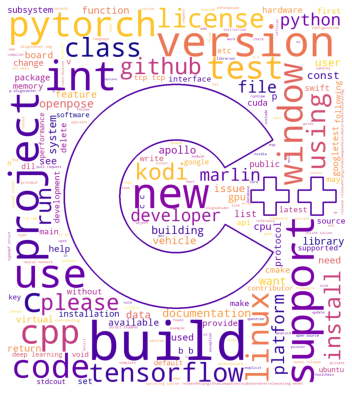

In [49]:
c_mask = np.array(Image.open("C.png"))
wc = WordCloud(background_color="white", colormap='plasma', mask=c_mask, contour_width=5, contour_color='#5302a3').generate(c_words)
plt.imshow(wc)
plt.axis("off")
plt.show()